# Tweet Finder

The purpose of this jupyter notebook is to walk through the process behind accessing Twitter's API to create a data set of Tweets. I will walk through each step as well as offer any insight I learned while working with Twitter's API. While there are plenty of sources online for how to access Twitter's API I had to go to several places to get all the information I needed to build this jupyter notebook. To sign up for access to Twitter's API is simple. Just go to the Twitter Developer webpage, make an account, and create an app. You will have to answer a few questions about what you will use the app for but as long as Twitter doesn't recieve any red flags you will get your keys in no time. 

# Imports

In [1]:
#import os
import tweepy as tw
import pandas as pd
import re
import numpy as np
import json
import csv
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline


Most of these imports will look familiar if you have any experience with Python. The one that stands out in this case though is tweepy. Tweepy is a Python library made specifically for accessing Twitter's API. You can pull tweets, post tweets, analyze tweets, etc.

# Functions

An important thing to remember with API's is to keep your keys and other valuable information away from anyone who comes across your code. These keys are specifically generated for your access to the API. You wouldn't want someone to abuse your keys and have your access to Twitter taken away. The following function opens up the .secret file you should have saved on your own machine and never uploaded to GitHub. 

In [2]:
def get_keys(path):
    """Using a specific file path on your computer or wherever you have your
    twitter keys saved this function will open that file and load the keys"""
    
    with open(path) as f:
        return json.load(f)

In [3]:
def remove_pattern(input_txt, pattern):
    """Takes in all the twitter text and whatever pattern you want to get rid
    of and cleans the text"""
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

In [4]:
def clean_tweets(tweets):
    """Using the remove_pattern() function, this function specifies what data
    to send as well as what pattern you would like eliminate from the tweets"""
    
    # remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    # remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z#]", " ")
    return tweets

# Accessing Twitter's API

Like I mentioned earlier, you should save your keys in a local file that will not be uploaded anywhere. You can easily access the information yourself but you will not be vulnerable to someone abusing the API with your keys. 

In [5]:
keys = get_keys("/Users/Andy/.secret/twitter_api.json")

In [6]:
consumer_key = keys['consumer_key']
consumer_secret = keys['consumer_secret']
access_token = keys['access_token']
access_token_secret = keys['access_token_secret']

In [7]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

If you have accessed API's before than the above code should look familiar. If not I will briefly explain what is going on. The process begins with registering our client application with Twitter. The next step is cerating an OAuthHandler instance  that we pass our consumer token and secret to. Unlike basic authorization, we must do the OAuth "dance" before we can start using the API. After equipping OAuthHandler with an access token you can then set up the API. Using  wait_on_rate_limit=True allows for the code to keep running until your rate limit is refreshed instead of just giving you an error. 

# Searching for Tweets

The objective of this project is to build a human-like customer service bot using NLP algorithms and models. In order to do this though a data set is required for the models to learn on. I found 10 twitter handles that are known for their customer service tweets and helpful information. From these 10 accounts I pulled as many tweets as I could. Now just becuase you make a query for 1,000 tweets does not mean you will recieve that many. I am not sure why the number varies, but when you are pulling tweets from a single twitter handle sometimes you recieve less than you asked for. While this is probably to protect twitter users, it gets in the way of pulling enough tweets at points. However, I believe I have managed to compile enough tweets.

In [8]:
twitter_accounts = ["from:XboxSupport", "from:UPSHelp", "from:JetBlue", "from:NikeSupport", "from:ComcastCares",
                   "from:AmazonHelp", "from:Zappos_Service", "from:AskTarget", "from:Tesco", "from:Lululemon"]

The following code is just a loop to go through all the accounts that I want a pull the latest 2,000 or so tweets. There are many more options for searching with the tweepy.Cursor however this was sufficient for my purposes. The Twitter Developer page shows you all the options and can help you narrow down your search for specific information but beware there are a lot of useless tweets on Twitter.

In [9]:
tweet_list = []
for account in twitter_accounts:
    tweets = tw.Cursor(api.search,
                      q=account,
                      lang='en',).items(2000)
    new_tweets = [tweet.text for tweet in tweets]
    tweet_list += new_tweets
    print(account)

from:XboxSupport
from:UPSHelp
from:JetBlue
from:NikeSupport
from:ComcastCares
from:AmazonHelp
from:Zappos_Service
from:AskTarget
from:Tesco
from:Lululemon


In [10]:
tweet_list

['Our teams are now reporting that this is resolved! Downloads should be working normally, so please feel free to giv… https://t.co/tFCW98UpyE',
 'RT @MojangStatus: Minecraft Bedrock - iOS only: some players have said they can log in if they switched to cellular data. We are continuing…',
 'We’ve heard that some of you are having trouble downloading purchased content. Our investigative teams are working… https://t.co/stMWzuHHtA',
 'We just received word that users should now be able to access purchased content again. We appreciate your reports.… https://t.co/85Q9cr9IdE',
 'We understand some of you are also having trouble accessing purchased content and in-game content on the Xbox One.… https://t.co/Bceb3MJiCd',
 "We've received word that some of you are having trouble downloading purchased content on the Xbox One. Our team is… https://t.co/1CUSwWAilY",
 'Our teams have let us know that you should now be able to download previously purchased content. Thank you for your… https://t.co/jJ

In [11]:
len(tweet_list)

7942

In [12]:
tweets = clean_tweets(tweet_list)

In [13]:
tweets

array(['Our teams are now reporting that this is resolved! Downloads should be working normally, so please feel free to giv… ',
       ' Minecraft Bedrock - iOS only: some players have said they can log in if they switched to cellular data. We are continuing…',
       'We’ve heard that some of you are having trouble downloading purchased content. Our investigative teams are working… ',
       ..., ' Reasonable.', ' Took the words right out of our mouth.',
       ' We totally get it—rest assured your feedback is noted.'],
      dtype='<U134')

Now all the tweets have been compiled as one giant list of strings. All handles have been removed as well as any links or media. Also any special characters that may bother an NLP model are removed as well. The tweets are clean and ready to be saved into a csv file to be used in another notebook.

# Building a Word Cloud

For a nice visual, I wanted to create a word cloud out of the dataset, just to see what all is in the set as well as what words I can expect to have a larger impact on the text generation of the NLP models in later notebooks

There are 789498 words in all the tweets


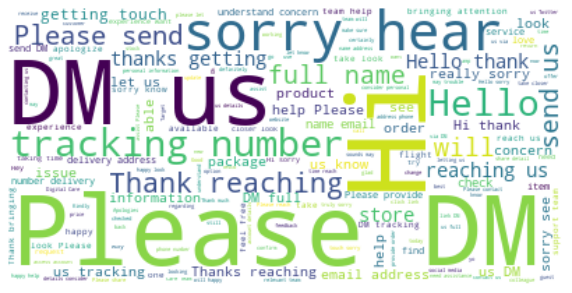

In [14]:
text = " ".join(tweet for tweet in tweets)
print("There are {} words in all the tweets".format(len(text)))

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

As you can see most of the tweets are either apologizing for an issue or asking for further information to resolve and issue. So we should see tweets generated in later notebooks with similar words. 

# Saving as a CSV File

In [15]:
with open('customer_service_data.csv', 'w', newline='' , encoding='utf-8') as myfile:
    wr = csv.writer(myfile, delimiter=',')
    wr.writerow(tweets)

That's it, now you have a file loaded with tweets ready to be analyzed and used to teach some NLP models to hopefully sound human and to be able to tweet. 